## The scenario

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

## Steps
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [97]:
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox, jarque_bera, normaltest
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from IPython.display import Markdown, display
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
def printmd(string):
    "prints text in bold"
    display(Markdown(string))

import warnings
warnings.filterwarnings(action="ignore")


## Step1: Load the houseprices data from Thinkful's database.

In [98]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

house_prices_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Step2: Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.


Let us move the saleprice column to the front:

In [99]:
# get a list of columns
cols = list(house_prices_df)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('saleprice')))

# use ix to reorder
house_prices_df = house_prices_df.ix[:, cols]

house_prices_df.head()

,saleprice,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,...,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
0,208500,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,2,2008,WD,Normal
1,181500,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,5,2007,WD,Normal
2,223500,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,9,2008,WD,Normal
3,140000,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,250000,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,12,2008,WD,Normal


### Exploratory Data Analysis

Let us look at the target model's distribution:

Mean: $180921


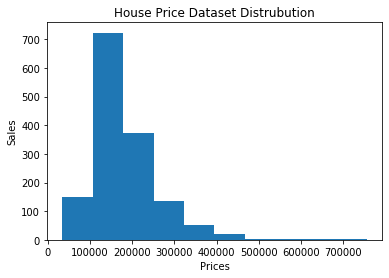

In [100]:
print('Mean: ${}'.format(round(np.mean(house_prices_df.saleprice))))
plt.hist(house_prices_df.saleprice)
plt.title('House Price Dataset Distrubution')
plt.xlabel('Prices')
plt.xticks()
plt.ylabel('Sales')
plt.show()

The target variable is right-skewed. The mean is 180,921 and prices reach a stretch above 700,000.

#### Missing Values

Let us take a look at the missing data:

In [101]:
#count missing values
missing_vals = (house_prices_df.isnull().sum()/len(house_prices_df)).sort_values(ascending=False)

# keep column names that do have them
missing_vals = missing_vals[missing_vals > 0]

# data types
missValDTypes = house_prices_df[missing_vals.index.to_list()].dtypes

printmd("**Missing value percentages:** Total values: {}".format(len(house_prices_df)))
print(missing_vals, '\n')


**Missing value percentages:** Total values: 1460

poolqc         0.995
miscfeature    0.963
alley          0.938
fence          0.808
fireplacequ    0.473
lotfrontage    0.177
garageyrblt    0.055
garagequal     0.055
garagecond     0.055
garagefinish   0.055
garagetype     0.055
bsmtexposure   0.026
bsmtfintype2   0.026
bsmtfintype1   0.025
bsmtqual       0.025
bsmtcond       0.025
masvnrarea     0.005
masvnrtype     0.005
electrical     0.001
dtype: float64 



### Treat missing values by replacing the first few missing values with 0. drop the entire column when missing vals are by random.

Looking at missing values, the first few features from poolqc to lotfrontage are amenities/features that do not exist in many houses. 

#### Descriptive Statistics

In [102]:
house_prices_df['saleprice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: saleprice, dtype: float64

Looks like houses can be sold for as low as 34,900 and as high as 755,000, due to their year built, location, type, or any other feature. 

The median for most buyers is 163,000, which is less than the 180,921 mean. This validates our finding in the distribution plot above that the data is not normally distributed.

### Univariate & Multivariate Analysis

In [103]:
# Let us see the correlation of features with the sale price
correlation = house_prices_df.corr()
correlation = correlation.sort_values(by=['saleprice'], ascending=False)

correlation[['saleprice']]

,saleprice
saleprice,1.000
overallqual,0.791
grlivarea,0.709
garagecars,0.640
garagearea,0.623
totalbsmtsf,0.614
firstflrsf,0.606
fullbath,0.561
totrmsabvgrd,0.534
yearbuilt,0.523


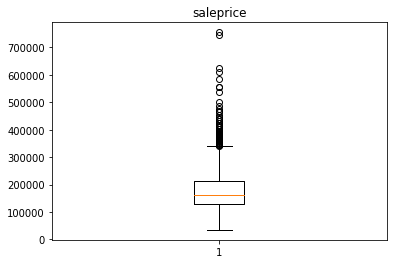

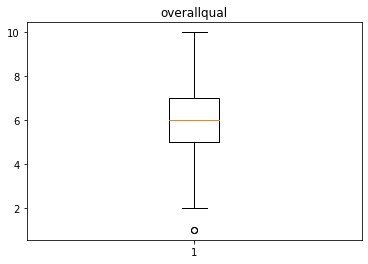

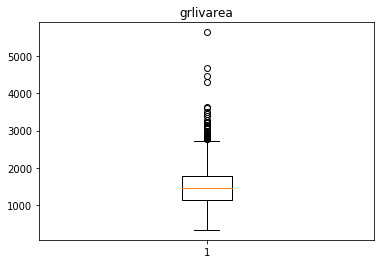

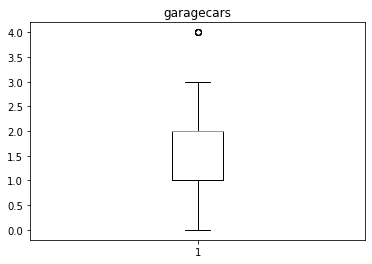

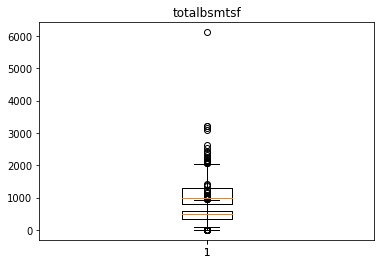

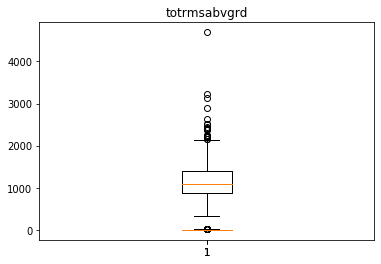

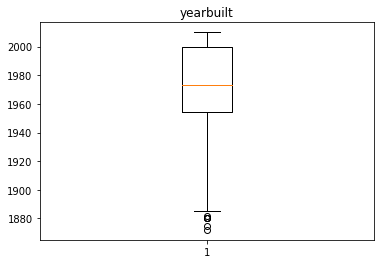

In [104]:
# Plot each of the 10 variables
plt.boxplot(house_prices_df['saleprice'])
plt.title('saleprice')
plt.show()
plt.boxplot(house_prices_df['overallqual'])
plt.title('overallqual')
plt.show()
plt.boxplot(house_prices_df['grlivarea'])
plt.title('grlivarea')
plt.show()
plt.boxplot(house_prices_df['garagecars'])
plt.title('garagecars')
plt.show()
plt.boxplot(house_prices_df['garagearea'])
plt.title('garagearea')
plt.boxplot(house_prices_df['totalbsmtsf'])
plt.title('totalbsmtsf')
plt.show()
plt.boxplot(house_prices_df['firstflrsf'])
plt.title('firstflrsf')
plt.boxplot(house_prices_df['fullbath'])
plt.title('fullbath')
plt.boxplot(house_prices_df['totrmsabvgrd'])
plt.title('totrmsabvgrd')
plt.show()
plt.boxplot(house_prices_df['yearbuilt'])
plt.title('yearbuilt')
plt.show()


Based on the above boxplots, we see that saleprice, grlivearea, totalbsmtsf, totrmsabvgrd and yearbuilt features have outliers which may skew our data.

Now Let us do univariate analysis and visualize the distributions of each of these features:

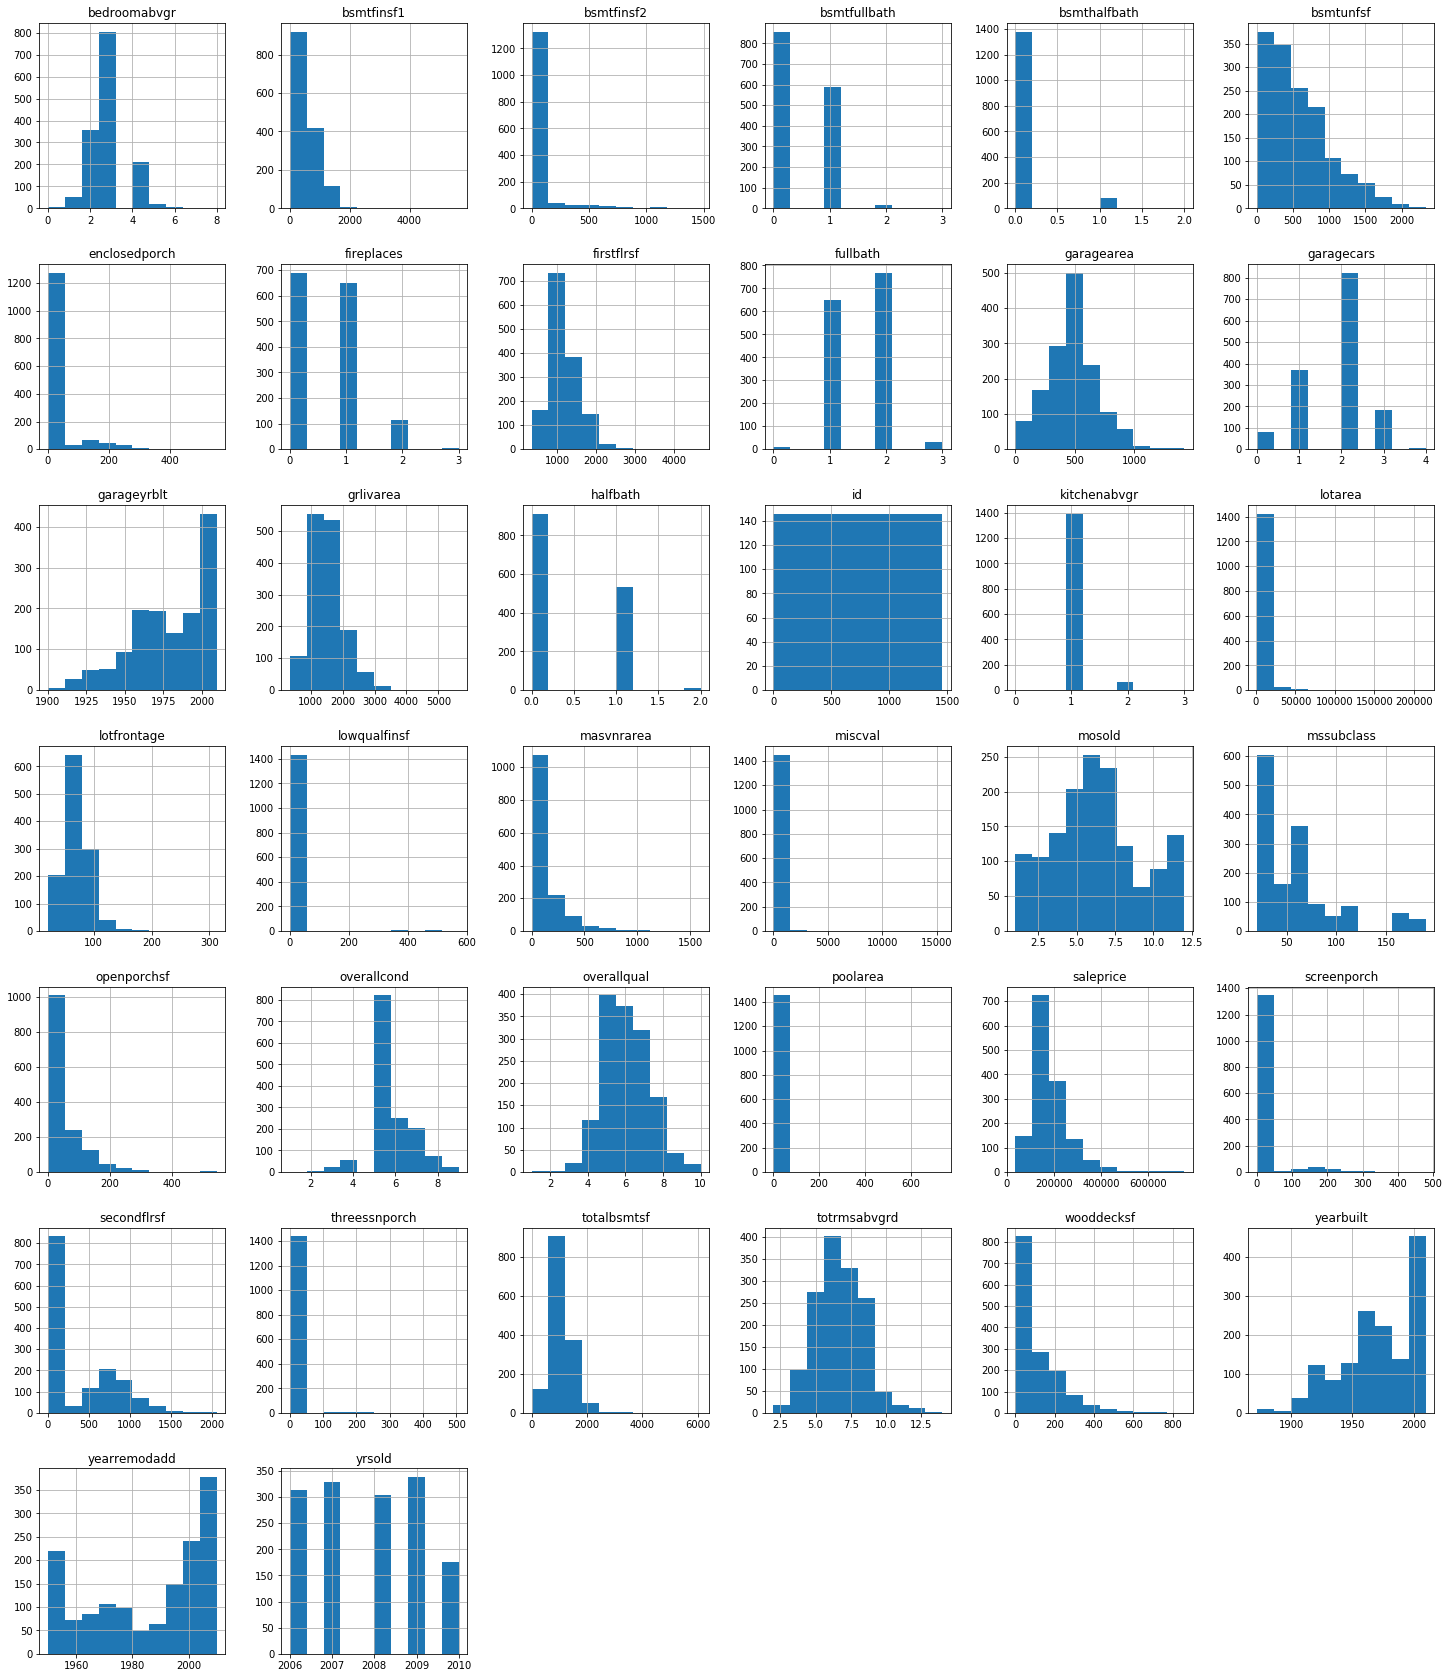

In [105]:
house_prices_df.hist(figsize=(25,30))
plt.show()

Most features are not normally distributed. This goes against one of assumptions Multivariate normality for regression models. Since the data is not normally distributed a non-linear transformation (e.g., log-transformation) might fix this issue.

## Data Cleaning

Let us drop the unnecessary columns based on the missing value percentages. i.e. poolqc, miscfeature, alley, fence, fireplacequ, lotfrontage.

And later perform data cleaning.

In [106]:

# Columns to be dropped
drop_cols = missing_vals[:5].index.to_list()
drop_cols.extend(['id'])

# Columns for data cleaning
data_clean_cols = {'garage':[i for i in missing_vals.index.to_list() if i.startswith('garage')],
                 'basement':[i for i in missing_vals.index.to_list() if i.startswith('bsmt')],
                 'etc':['masvnrarea','masvnrtype','electrical']}

# Drop columns marked for removal and treat the NaN values
house_prices_df.drop(columns=drop_cols, inplace=True)
house_prices_df = house_prices_df.replace([np.inf, -np.inf], np.nan).dropna(how="all")


In [107]:
# Deal with missing values by reviewing the unique values in the given column
for key in data_clean_cols.keys():
    print("\nkey="+key)
    print("values")
    for val in data_clean_cols[key]:
        print (val)
        #print(house_prices_df[val].describe())
        #print(len(house_prices_df[val].value_counts()))
        if len(house_prices_df[val].value_counts()) <= 7:
            print("{}".format(house_prices_df[val].value_counts()))
        else:
            print("{}".format(house_prices_df[val].describe()))    


key=garage
values
garageyrblt
count   1379.000
mean    1978.506
std       24.690
min     1900.000
25%     1961.000
50%     1980.000
75%     2002.000
max     2010.000
Name: garageyrblt, dtype: float64
garagequal
TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: garagequal, dtype: int64
garagecond
TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: garagecond, dtype: int64
garagefinish
Unf    605
RFn    422
Fin    352
Name: garagefinish, dtype: int64
garagetype
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: garagetype, dtype: int64

key=basement
values
bsmtexposure
No    953
Av    221
Gd    134
Mn    114
Name: bsmtexposure, dtype: int64
bsmtfintype2
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: bsmtfintype2, dtype: int64
bsmtfintype1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: bsmtfintype1, dtype: int64
bsmtqual
TA    649
Gd    618
Ex    121
Fa     35
Name: bs

Based on these values and their counts or description, we will fill in missing values accordingly:

In [108]:
# Create a dictionary containing the value to replace missing values in each column
fill_with = {'garageyrblt': 0, 'garagequal': 'TA', 'garagecond': 'TA', 'garagefinish': 'Unf','garagetype':'No',
             'bsmtexposure':'No','bsmtfintype2':'Unf','bsmtfintype1':'Unf','bsmtqual':'TA','bsmtcond':'TA',
             'masvnrarea':0,'masvnrtype':'None','electrical':'SBrkr'}
house_prices_df = house_prices_df.fillna(value=fill_with)

Next, let's transform numerical values and try to reach distributions close to normal. Since it is hard to visualize the normality in all columns at once, we will use the Jargue-Bera and normality tests:

In [109]:
house_prices_df.shape

(1460, 75)

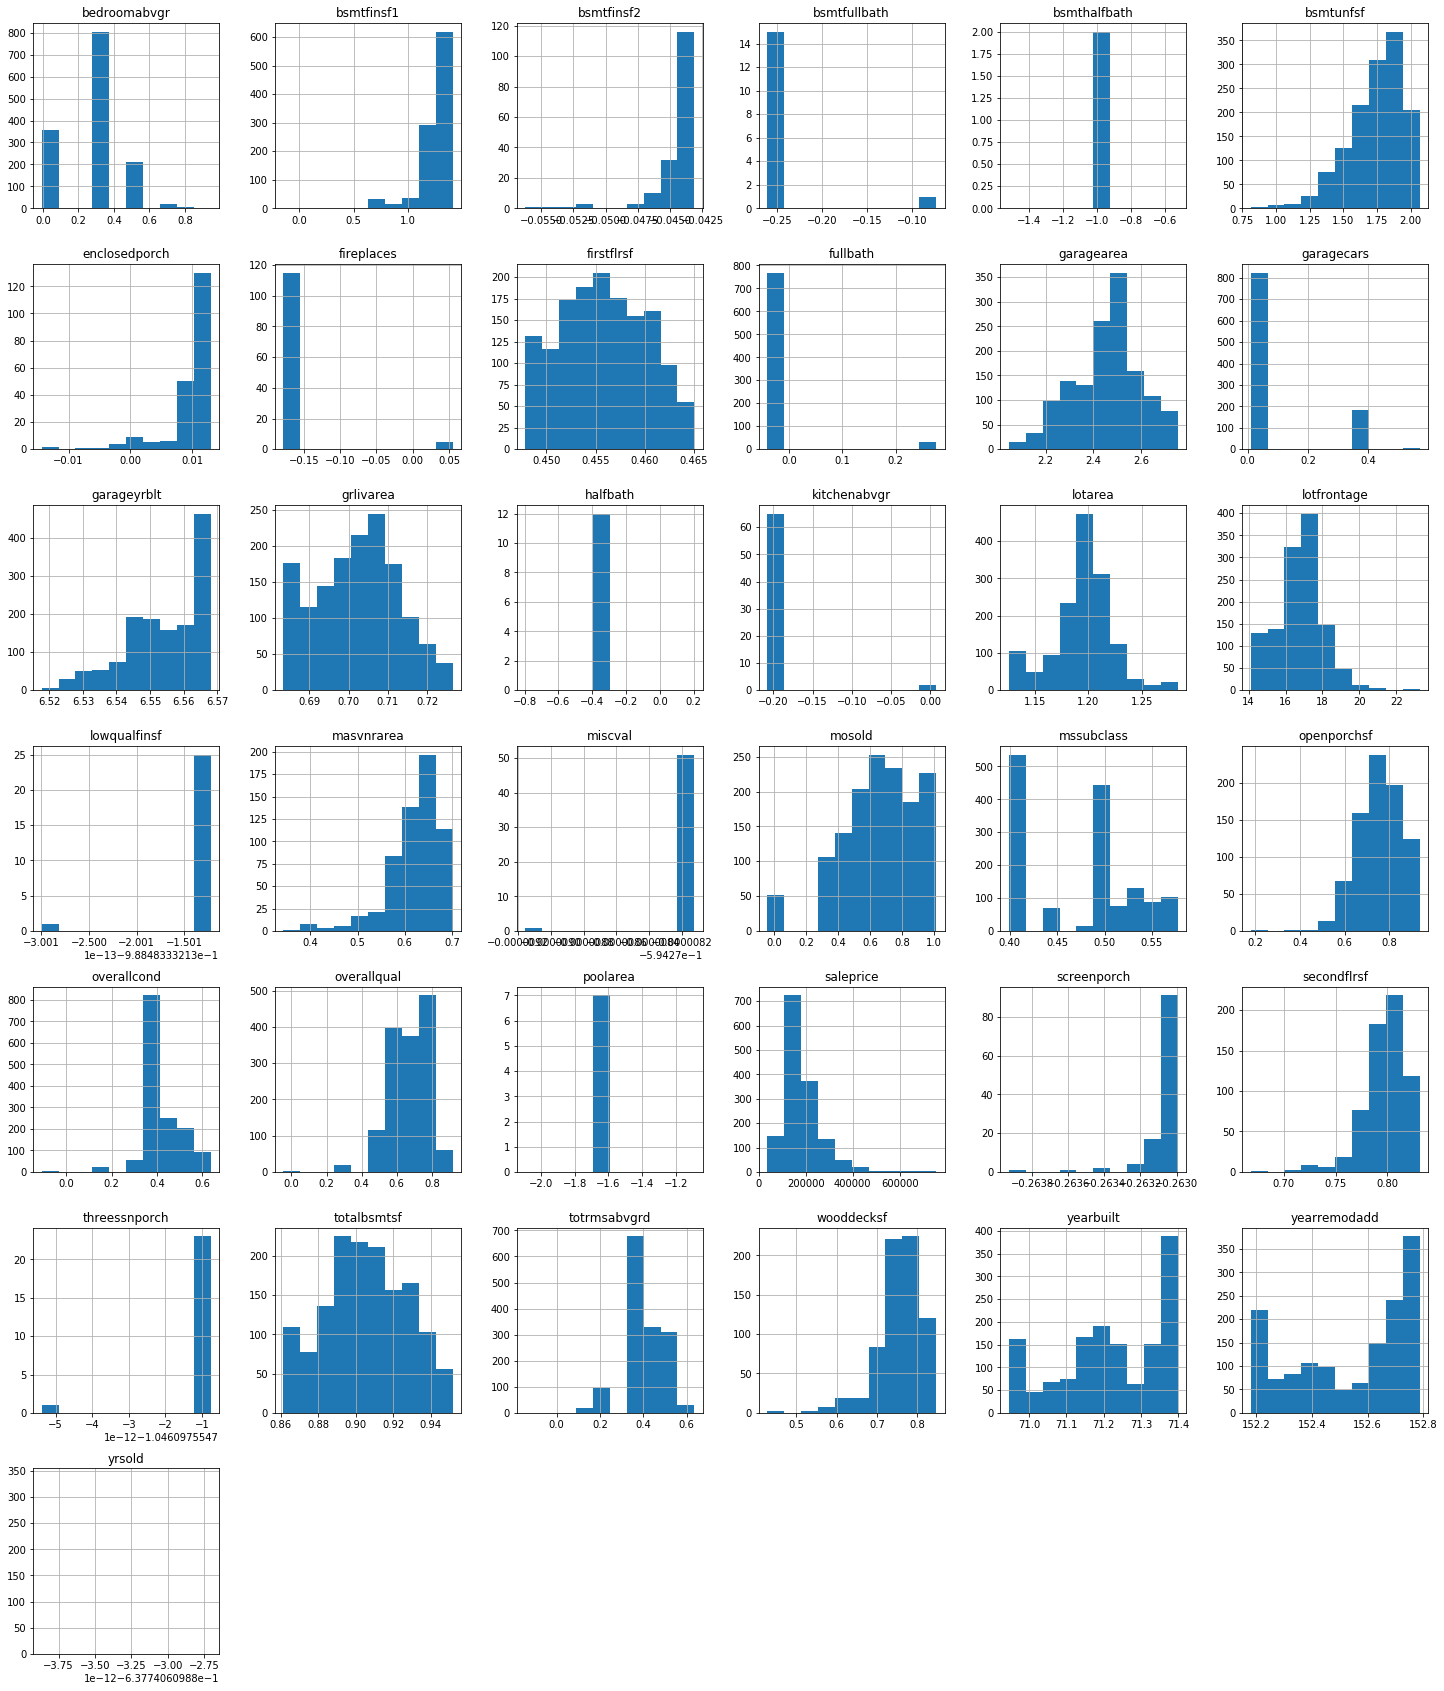

In [110]:
def transform(house_prices_df, target, transformations=[],box_cox=False):
    """ Winsorizes, transforms, and cleans numeric columns 
        transformations parameter is a list of functions fed to pd.series.apply(), repectively.
        returns transformed dataframe
    """
    
    def boxcox_prep(val):
        """ Transforms values of 0 or less to 0.1 """
    
        if val <= 0:
            return 0.1
        return val
    
    # Pick numerical columns
    numeric_cols = house_prices_df.select_dtypes(include=[np.number]).columns.to_list()
    numeric_cols.remove(target)
    
    # Winsorize, log-transform the square root, and plot
    for col in numeric_cols:
        if len(np.unique(house_prices_df[col])) > 20:
            house_prices_df[col] = winsorize(house_prices_df[col], limits = (0.05,0.01))
        if box_cox or any(item in transformations for item in [np.log,np.sqrt]):
            house_prices_df[col] = house_prices_df[col].apply(boxcox_prep)
            house_prices_df[col],_ = boxcox(house_prices_df[col])
        for transformation in transformations:
            house_prices_df[col] = house_prices_df[col].apply(transformation)
        house_prices_df = house_prices_df.replace([np.inf, -np.inf], np.nan).dropna(how="all")
    return house_prices_df

transform(house_prices_df,'saleprice',[np.sqrt,np.log]).hist(figsize=(25,30)) 
plt.show()

Winsorizing and transforming values did bring distribution of some variables closer to normal. This should contribute to enhancing our regression models.

Let us look at each categorical feature in terms of saleprice and see how each value affects the saleprice and how it differs from another value for the same feature:

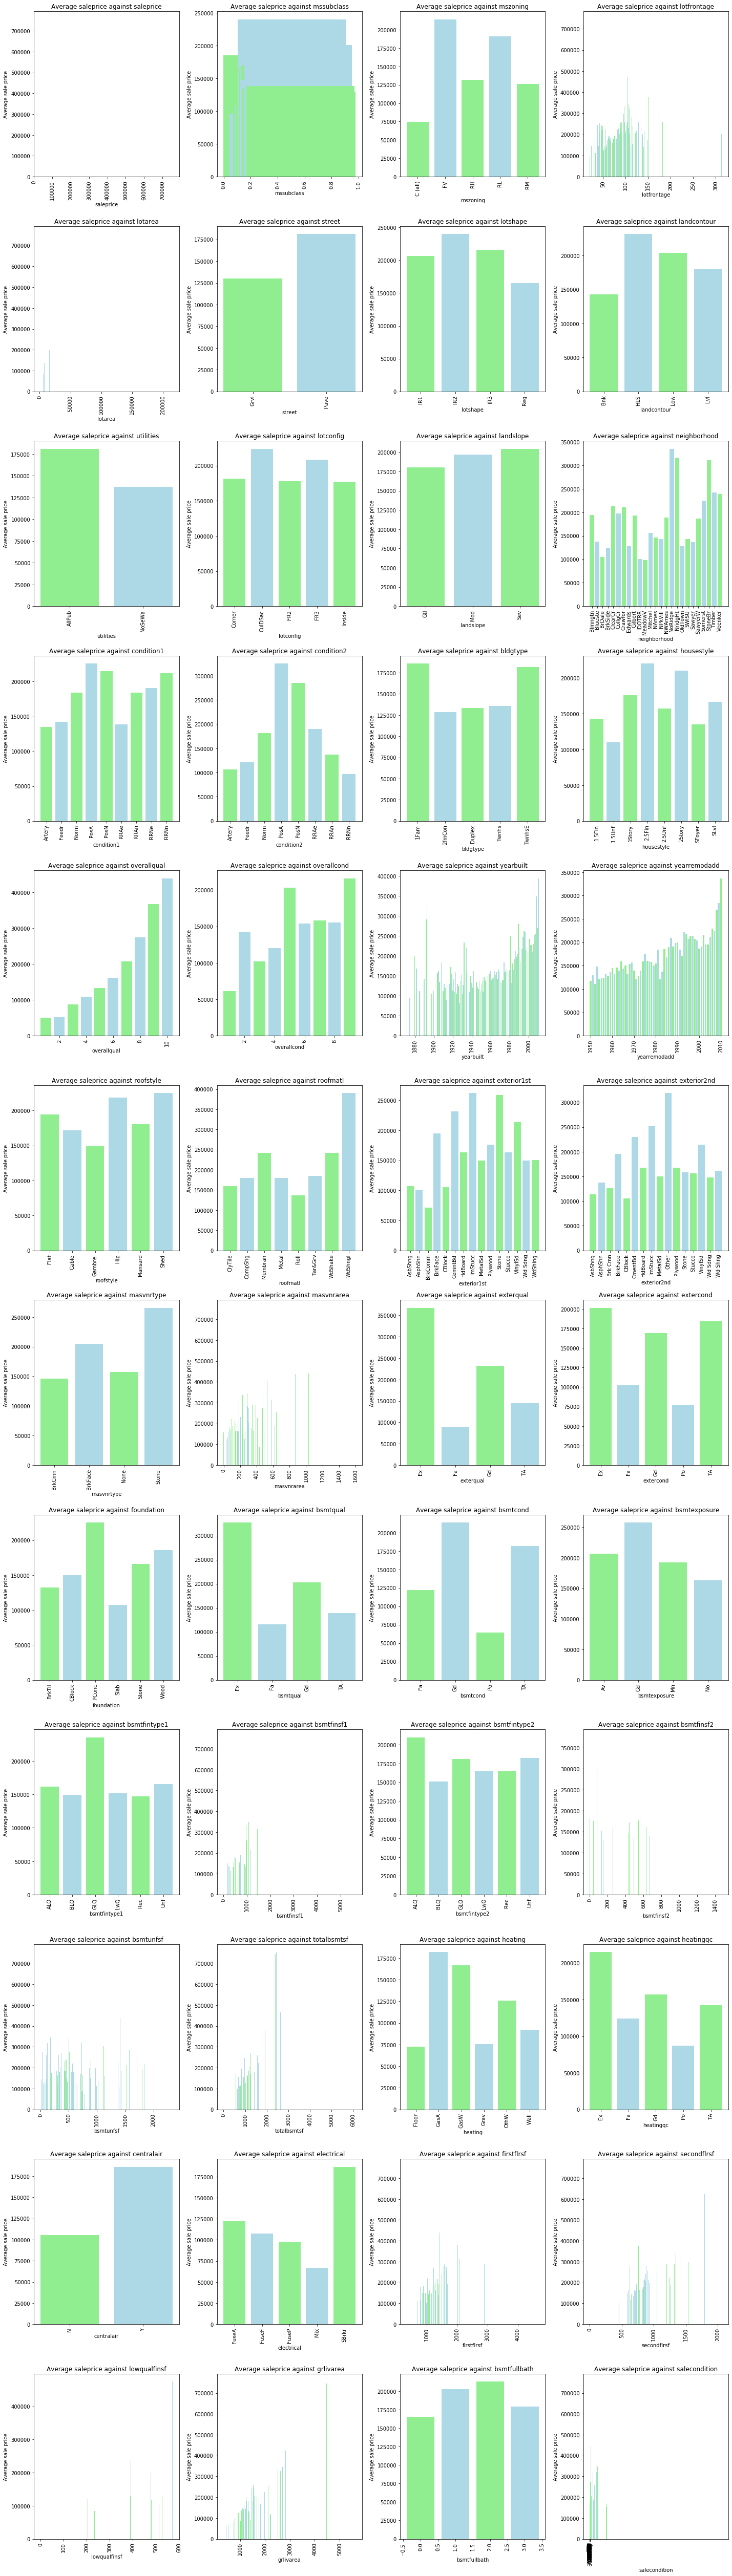

In [111]:
# Plot different bar plots for features against the target
plt.figure(figsize=(20,70))
i = 1
for index, column in enumerate(house_prices_df.columns):
    plt.subplot(12,4,i)
    
    if i < 48:
        i += 1
    else:
        i = 48
    
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, house_prices_df.groupby(column)["saleprice"].mean(),color=('lightgreen','lightblue'))
    plt.title("Average saleprice against {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

# Feature Engineering

In [112]:
print('\n')
printmd('**Neighborhoods ordered from most to least expensive**')
# Group data by neighborhood
house_prices_df.groupby("neighborhood").mean().sort_values(by=['saleprice'],ascending=False)

**Neighborhoods ordered from most to least expensive**

,saleprice,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold
neighborhood,,,,,,,,,,,,,,,,,,,,,
NoRidge,335295.317,0.488,91.879,14218.902,7.927,5.220,1995.439,1996.659,420.024,829.756,...,705.927,200.220,75.122,29.244,0.000,13.512,13.537,0.000,6.244,2007.829
NridgHt,316270.623,0.475,81.882,10887.948,8.260,5.000,2005.675,2006.169,329.545,696.779,...,745.753,151.701,75.532,0.000,3.948,15.039,0.000,0.000,6.857,2007.818
StoneBr,310499.000,0.501,62.700,10671.920,8.160,5.000,1998.480,1998.840,182.760,822.920,...,631.520,164.960,51.080,25.920,6.720,27.760,0.000,0.000,7.640,2007.920
Timber,242247.447,0.441,80.133,23664.237,7.158,5.132,1992.842,1993.342,159.947,708.500,...,621.605,143.842,50.789,10.342,0.000,15.421,0.000,18.421,5.921,2007.816
Veenker,238772.727,0.473,59.714,15606.000,6.727,6.273,1982.364,1989.818,32.727,819.909,...,546.909,190.545,50.182,0.000,0.000,56.364,0.000,0.000,7.000,2007.000
Somerst,225379.837,0.484,64.667,7840.872,7.337,5.035,2004.988,2005.302,150.326,327.198,...,630.628,69.174,101.174,0.000,0.000,5.395,0.000,0.000,6.233,2007.744
ClearCr,212565.429,0.476,83.462,30875.750,5.893,5.679,1966.571,1983.750,84.571,620.893,...,468.429,188.821,64.821,32.536,4.643,34.929,0.000,32.143,6.786,2007.786
Crawfor,210624.725,0.484,71.805,11809.686,6.275,6.588,1941.549,1979.196,81.118,466.804,...,410.078,52.569,27.000,46.176,10.804,30.176,0.000,49.020,6.863,2007.490
CollgCr,197965.773,0.452,71.683,9619.147,6.640,5.240,1997.887,1999.140,97.227,456.587,...,552.580,114.320,51.720,0.227,2.593,4.300,0.000,16.333,6.140,2007.807


NoRidge, NridgHt and StoneBr are the most expensive neighborhoods in this dataset. Some of their features are significantly different than those of other neighborhoods. Note that the bin numbers are:
    
    0 = fair
    1 = good
    2 = very good
    3 = luxurious
    
We will define a function & name it *classify_neighborhood* to add our own neighborhood categories to the dataset:

In [113]:
def classify_neighborhood(saleprice):
    """ puts houses in preset neighborhood bins """
    
    nbr_class = {0:'saleprice < 120000',
                 1:'saleprice >= 120000 and saleprice < 200000',
                 2:'saleprice >= 200000 and saleprice < 300000',
                 3:'saleprice >= 300000'}
    for class_level in nbr_class.keys():
        if eval(nbr_class[class_level]):
            return class_level

house_prices_df['neighborhood_class'] = house_prices_df['saleprice'].apply(classify_neighborhood)

In [114]:
# make the correlation matrix.
corr_mat_houses = house_prices_df.corr()

printmd('\n **Correlation dataframe sorted by correlation with saleprice descending:**')
corr_mat_houses.sort_values(by=['saleprice'],ascending=False)


 **Correlation dataframe sorted by correlation with saleprice descending:**

,saleprice,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,neighborhood_class
saleprice,1.000,-0.021,0.352,0.264,0.791,-0.078,0.523,0.507,0.473,0.386,...,0.324,0.316,-0.129,0.045,0.111,0.092,-0.021,0.046,-0.029,0.892
neighborhood_class,0.892,-0.035,0.348,0.247,0.755,-0.059,0.539,0.523,0.401,0.374,...,0.319,0.314,-0.131,0.053,0.096,0.043,-0.020,0.057,-0.023,1.000
overallqual,0.791,0.086,0.252,0.106,1.000,-0.092,0.572,0.551,0.407,0.240,...,0.239,0.309,-0.114,0.030,0.065,0.065,-0.031,0.071,-0.027,0.755
grlivarea,0.709,0.224,0.403,0.263,0.593,-0.080,0.199,0.287,0.388,0.208,...,0.247,0.330,0.009,0.021,0.102,0.170,-0.002,0.050,-0.037,0.652
garagecars,0.640,-0.007,0.286,0.155,0.601,-0.186,0.538,0.421,0.362,0.224,...,0.226,0.214,-0.151,0.036,0.050,0.021,-0.043,0.041,-0.039,0.626
garagearea,0.623,-0.075,0.345,0.180,0.562,-0.152,0.479,0.372,0.371,0.297,...,0.225,0.241,-0.122,0.035,0.051,0.061,-0.027,0.028,-0.027,0.613
totalbsmtsf,0.614,-0.297,0.392,0.261,0.538,-0.171,0.391,0.291,0.360,0.522,...,0.232,0.247,-0.095,0.037,0.084,0.126,-0.018,0.013,-0.015,0.588
firstflrsf,0.606,-0.305,0.457,0.299,0.476,-0.144,0.282,0.240,0.340,0.446,...,0.235,0.212,-0.065,0.056,0.089,0.132,-0.021,0.031,-0.014,0.566
fullbath,0.561,0.190,0.199,0.126,0.551,-0.194,0.468,0.439,0.273,0.059,...,0.188,0.260,-0.115,0.035,-0.008,0.050,-0.014,0.056,-0.020,0.529
totrmsabvgrd,0.534,0.192,0.352,0.190,0.427,-0.058,0.096,0.192,0.280,0.044,...,0.166,0.234,0.004,-0.007,0.059,0.084,0.025,0.037,-0.035,0.498


We choose the positively correlated features that are in the top rows. Let us visualize this table with correlation matrix,  with threshold = 0.64:

**Correlation Matrix (filtered for correlation above 0.64):**

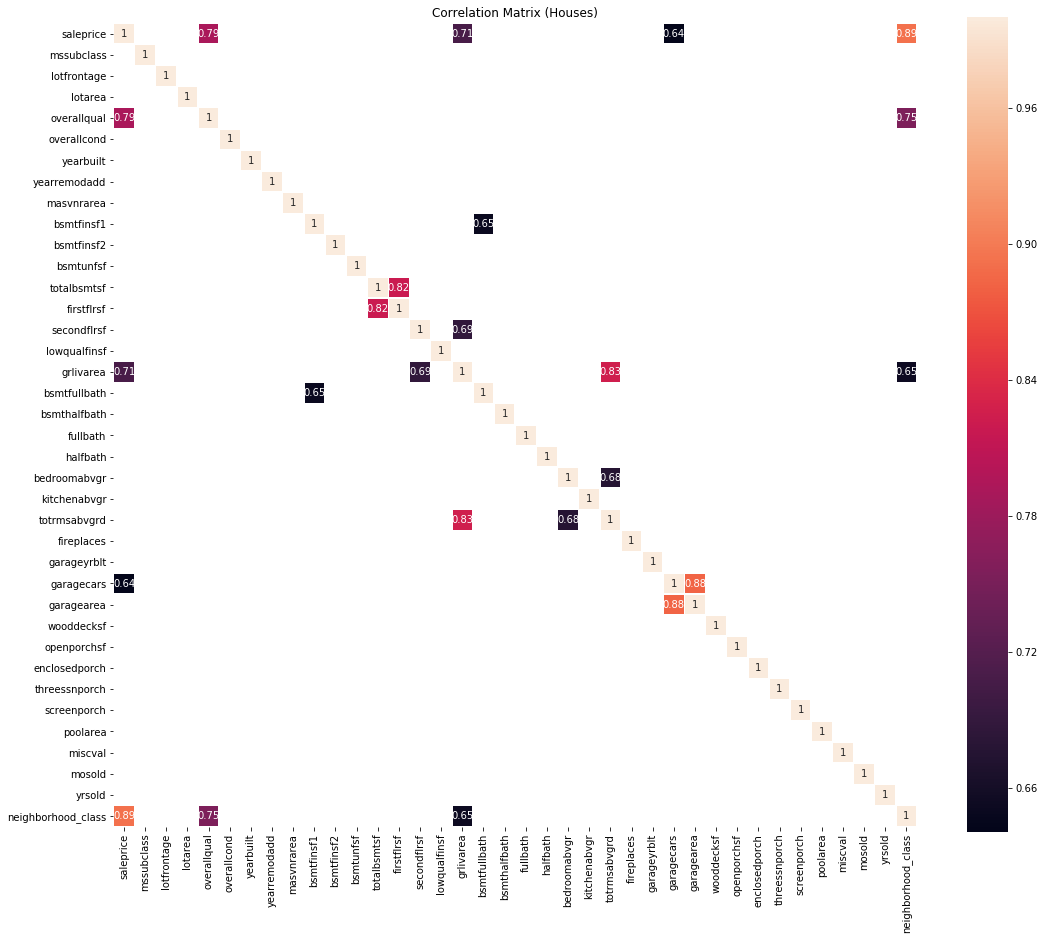

features are: ['overallqual', 'grlivarea', 'garagecars', 'neighborhood_class']


In [115]:
def draw_heatmap(df,corr_thresh=.7):
    """ Draws heatmap out of a dataframe. 
        Set corr_thresh to 0 for full heatmap,
        or keep default for strong correlation
    """
    
    # make the correlation matrix.
    corr_mat = df.corr()

    # move the column to head of list using index, pop and insert
    cols = list(corr_mat)
    cols.insert(0, cols.pop(cols.index('saleprice')))

    # reorder
    corr_mat = corr_mat.ix[:, cols]
    corr_mat.sort_values(by=['saleprice'],ascending=False)

    # figure aesthetics
    plt.figure(figsize=(18,15))
    plt.plot()
    
    # draw the heatmap using seaborn.
    sns.heatmap(corr_mat[(corr_mat > corr_thresh)], square=True, annot=True, linewidths=.5)
    plt.title("Correlation Matrix (Houses)")
    printmd("**Correlation Matrix (filtered for correlation above {}):**".format(corr_thresh))
    plt.show()
    
    # return features that correlate with the target equal to corr_thresh or higher
    features = corr_mat[(corr_mat > corr_thresh)]
    features = features.index[features['saleprice'] >= corr_thresh].tolist()
    features.remove('saleprice')
    print('features are: {}'.format(features))
    return features

corr_thresh = 0.64
features = draw_heatmap(house_prices_df,corr_thresh)


    
# del corr_mat_houses

This model is based on features selected, removing overallqual and grlivarea since they both have high correlation with neighborhood_class.

**Note:** Alternatively we could perform PCA analysis to to extract the most important variables.

In [116]:
# Initial model prep
temp_df = house_prices_df[['saleprice',
              'overallqual',
              'grlivarea',
              'garagecars']]

def log_prep(temp_df):
    """takes in the chosen temp_df for the model and outputs X & Y with saleprice log-transformed"""
    
    # Log-transform salesprice values & drop saleprice
    temp_df['saleprice_log'] = np.log(temp_df['saleprice'])
    temp_df.drop(columns=['saleprice'],inplace=True)
    
    # designate features
    features = list(temp_df.columns)
    features.remove('saleprice_log')
    print('features (len: {}): {}\ntarget: {}'.format(len(features),{i for i in features},list(set(set(temp_df.columns)-set(features)))))

    # X & Y
    X = temp_df[features]
    Y = temp_df['saleprice_log']
    return X,Y

X, Y = log_prep(temp_df)

features (len: 3): {'overallqual', 'grlivarea', 'garagecars'}
target: ['saleprice_log']


## Step 3: Now, split your data into train and test sets with test size as 20% of the observations.

In [117]:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


## Step 4:  Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!


## OLS

#### Model 1 : 



The following features are based on 0.7 or more correlation, and overallqual and grlivarea are removed due to correlating strongly with neighborhood_class :

### Try sklearn CV linear regression

In [118]:
features_1 = ['saleprice', 'neighborhood_class', 'garagecars']
temp_df = house_prices_df[features_1]

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1336.
Date:                Wed, 29 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:15:11   Log-Likelihood:                 292.72
No. Observations:                1168   AIC:                            -577.4
Df Residuals:                    1164   BIC:                            -557.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.5812      0.025    417.163      0.000      10.531      10.631
overallqual     0.1451      0.006     25.463      0.000       0.134       0.156
grlivarea       0.0002   1.32e-05     16.294      0.000       0.000       0.000
garagecars      0.1316      0.010     13.826      0.000       0.113       0.150
==============================================================================
Omnibus:                      376.882   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2581.221
Skew:                          -1.311   Prob(JB):                         0.00
Kurtosis:                       9.794   Cond. No.                     7.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 2 : 

In [120]:
# Initial model prep
features_2 = ['saleprice','overallqual','grlivarea','garagecars', 'totalbsmtsf', 'fullbath','yearbuilt', 'yearremodadd']
temp_df = house_prices_df[features_2]

X, Y = log_prep(temp_df)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

features (len: 7): {'overallqual', 'totalbsmtsf', 'garagecars', 'grlivarea', 'yearbuilt', 'yearremodadd', 'fullbath'}
target: ['saleprice_log']


In [122]:
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     712.1
Date:                Wed, 29 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:15:54   Log-Likelihood:                 395.39
No. Observations:                1168   AIC:                            -774.8
Df Residuals:                    1160   BIC:                            -734.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.2966      0.658      5.006      0.000       2.005       4.589
overallqual      0.0980      0.006     15.935      0.000       0.086       0.110
grlivarea        0.0002   1.53e-05     15.616      0.000       0.000       0.000
garagecars       0.0912      0.009      9.815      0.000       0.073       0.109
totalbsmtsf      0.0001    1.4e-05      8.035      0.000    8.51e-05       0.000
fullbath        -0.0160      0.013     -1.189      0.235      -0.042       0.010
yearbuilt        0.0017      0.000      6.452      0.000       0.001       0.002
yearremodadd     0.0021      0.000      6.567      0.000       0.001       0.003
==============================================================================
Omnibus:                      797.249   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30517.342
Skew:                          -2.623   Prob(JB):                         0.00
Kurtosis:                      27.486   Cond. No.                     4.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R2 & Adj. R-squared, F-statistic are is higher, the AIC and BIC are lower compared to previous model.

#### Model 3 : 

In [123]:
features_3 = ['saleprice','garagecars', 'yearremodadd', 'totalbsmtsf', 'yearbuilt', 'fullbath', 'neighborhood_class']
temp_df = house_prices_df[features_3]

X, Y = log_prep(temp_df)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
print(features_3)

features (len: 6): {'totalbsmtsf', 'neighborhood_class', 'garagecars', 'yearbuilt', 'yearremodadd', 'fullbath'}
target: ['saleprice_log']
['saleprice', 'garagecars', 'yearremodadd', 'totalbsmtsf', 'yearbuilt', 'fullbath', 'neighborhood_class']


In [124]:
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1485.
Date:                Wed, 29 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:16:00   Log-Likelihood:                 683.47
No. Observations:                1168   AIC:                            -1353.
Df Residuals:                    1161   BIC:                            -1318.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.5487      0.483     17.688      0.000       7.600       9.497
garagecars             0.0697      0.007      9.617      0.000       0.055       0.084
yearremodadd           0.0012      0.000      4.638      0.000       0.001       0.002
totalbsmtsf         7.534e-05   1.09e-05      6.906      0.000    5.39e-05    9.67e-05
yearbuilt              0.0002      0.000      1.168      0.243      -0.000       0.001
fullbath               0.0765      0.009      8.624      0.000       0.059       0.094
neighborhood_class     0.3345      0.007     44.701      0.000       0.320       0.349
==============================================================================
Omnibus:                      279.741   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1493.346
Skew:                          -0.999   Prob(JB):                         0.00
Kurtosis:                       8.166   Cond. No.                     3.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The third model is the best fit as it has higher R Square, Adjusted R Square values and lower AIC, BIC values.

#### K-Fold Validation

In [125]:

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.8847226205152872
-----Test set statistics-----
R-squared of the model in test set is: 0.8729005149643211
Mean absolute error of the prediction is: 0.10706057361571164
Mean squared error of the prediction is: 0.021193569904969595
Root mean squared error of the prediction is: 0.1455801150740361
Mean absolute percentage error of the prediction is: 0.8962626006837158


In [126]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.8847226205152872
-----Test set statistics-----
R-squared of the model in test set is: 0.8729005149083144
Mean absolute error of the prediction is: 0.10706057366143293
Mean squared error of the prediction is: 0.02119356991430859
Root mean squared error of the prediction is: 0.1455801151061112
Mean absolute percentage error of the prediction is: 0.896262601065574


In [127]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 0.8847226205152872
-----Test set statistics-----
R-squared of the model in test set is: 0.8729005149406114
Mean absolute error of the prediction is: 0.10706057363320512
Mean squared error of the prediction is: 0.021193569908923137
Root mean squared error of the prediction is: 0.14558011508761468
Mean absolute percentage error of the prediction is: 0.8962626008296946


### Ridge Regression

In [128]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
a = 10
ridgeregr = Ridge(alpha=a) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8845729615816944
-----Test set statistics-----
R-squared of the model on the test set is: 0.8735038972954904
Mean absolute error of the prediction is: 0.10624374249285923
Mean squared error of the prediction is: 0.021092957179343907
Root mean squared error of the prediction is: 0.14523414605162213
Mean absolute percentage error of the prediction is: 0.889435319482297


## Lasso

In [129]:
lassoregr = Lasso(alpha=0.001) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8846811281115596
-----Test set statistics-----
R-squared of the model on the test set is: 0.8734200827080845
Mean absolute error of the prediction is: 0.10661611496240164
Mean squared error of the prediction is: 0.021106933084256086
Root mean squared error of the prediction is: 0.14528225316347515
Mean absolute percentage error of the prediction is: 0.8925505765314867


## ElasticNet regression


In [130]:
elasticregr = ElasticNet(alpha=0.001, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8847089450765142
-----Test set statistics-----
R-squared of the model on the test set is: 0.8732101689709613
Mean absolute error of the prediction is: 0.1067789534279698
Mean squared error of the prediction is: 0.021141935755277817
Root mean squared error of the prediction is: 0.1454026676346683
Mean absolute percentage error of the prediction is: 0.8939093003012419


The metrics are pretty much same for all the above regressions.

## Step 5: Evaluate your best model on the test set.



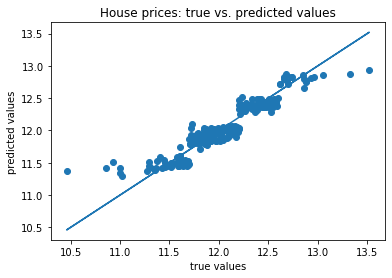

In [131]:
# predict house prices using test set
y_preds = results.predict(X_test)

# plot results against actual values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()

In [132]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Mean absolute error of the prediction is: 0.10706057366144107
Mean squared error of the prediction is: 0.021193569914310224
Root mean squared error of the prediction is: 0.14558011510611682
Mean absolute percentage error of the prediction is: 0.8962626010656427


The values for MAE, MSE, RMSE, and MAPE seems to be better for Model 3 predictions.

## Step 6:  So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


These variables can be obtained using the dates of house sales. Getting a range of years will enable us to obtain GDP (Gross Domestic Product), GNP (Gross National Product), and interest rate for the year of sale between 2006 and 2010:

In [137]:
# Based on World Bank national account data, we get the GDP and the bank interest rates
gdp = [13.86,14.48,14.72,14.42,14.96]
int_rate = [5.87, 5.4, 2, 0.5, 0.75]
yrs = [i for i in range(2006,2011)]
gdp = {i:n for i in yrs for n in gdp}
int_rate = {i:n for i in yrs for n in int_rate}

# add the 2 columns
house_prices_df['gdp'] = [gdp[i] for i in house_prices_df['yrsold']]
house_prices_df['int_rate'] = [int_rate[i] for i in house_prices_df['yrsold']]

#### Model 4

In [138]:
features_4 = features_3
features_4.extend(['gdp','int_rate'])

temp_df = house_prices_df[features_4]

X, Y = log_prep(temp_df)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

features (len: 8): {'totalbsmtsf', 'neighborhood_class', 'gdp', 'garagecars', 'int_rate', 'yearbuilt', 'yearremodadd', 'fullbath'}
target: ['saleprice_log']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1485.
Date:                Wed, 29 Jan 2020   Prob (F-statistic):               0.00
Time:                        15:17:32   Log-Likelihood:                 683.47
No. Observations:                1168   AIC:                            -1353.
Df Residuals:                    1161   BIC:                            -1318.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
garagecars             0.0697      0.007      9.617      0.000       0.055       0.084
yearremodadd           0.0012      0.000      4.638      0.000       0.001       0.002
totalbsmtsf         7.534e-05   1.09e-05      6.906      0.000    5.39e-05    9.67e-05
yearbuilt              0.0002      0.000      1.168      0.243      -0.000       0.001
fullbath               0.0765      0.009      8.624      0.000       0.059       0.094
neighborhood_class     0.3345      0.007     44.701      0.000       0.320       0.349
gdp                    0.5700      0.032     17.688      0.000       0.507       0.633
int_rate               0.0286      0.002     17.688      0.000       0.025       0.032
==============================================================================
Omnibus:                      279.741   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1493.346
Skew:                          -0.999   Prob(JB):                         0.00
Kurtosis:                       8.166   Cond. No.                     3.66e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.84e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

This model seems close to model 3 in any of the metrics. This may not perform any better than Model 3 with predictions:

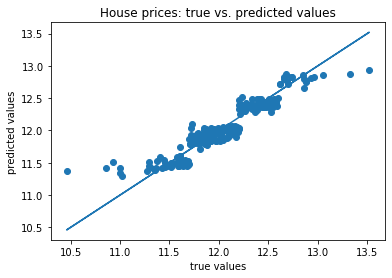

In [139]:
# predict house prices using test set
y_preds = results.predict(X_test)

# plot results against actual values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()

In [140]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Mean absolute error of the prediction is: 0.1070605736614417
Mean squared error of the prediction is: 0.021193569914309755
Root mean squared error of the prediction is: 0.1455801151061152
Mean absolute percentage error of the prediction is: 0.8962626010656459


As expected, Model 4 prediction was not better than Model 3. This may be due to the additional external features added in the model may not be specific to this housing market.

We may need to explore the factors that are influenced by the state of the economy, interest rates, real income and changes in the size of the population, crime rate, education. 